$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 1: Linear Regression

Jim Xu

831-156-383

## Overview

Using Stochastic Gradient Descent (SGD) to fit a Linear Regression Model by minimizing the Sum of Squared Errors(SSE).

## Method

#### 1. Data PreProcess
    
* ```Xtrain, Ttrain, Xtest, Ttest = shuffleIndice(X, T)```

Function ```shuffleIndice``` shuffles the X(variables) and T(target) data into two disjointed dataset for Training and Testing purpose.

In [1]:
def shuffleIndice(X, T):
    '''
    shuffle data samples to non-overlapping
    80% training and 20% testing
    '''
    nrows = X.shape[0]
    nTrain = int(round(nrows*0.8))
    nTest = nrows - nTrain
    rows = np.arange(nrows)
    np.random.shuffle(rows)
    trainIndices = rows[:nTrain]
    testIndices = rows[nTrain:]
    Xtrain = X[trainIndices, :]
    Ttrain = T[trainIndices, :]
    Xtest = X[testIndices, :]
    Ttest = T[testIndices, :]
    return Xtrain, Ttrain, Xtest, Ttest

#### 2. Data Standardize (z-score)
    
* ```means, stds, XStd = standardize(X, means = None, stds = None)```

Function ```standardize``` standardizes the X(variable) data by adjusting the values to have zero mean and unit variance in order to compare the relative importance of each input variable.

In [2]:
# http://nbviewer.jupyter.org/url/www.cs.colostate.edu/~anderson/cs445/notebooks/03%20Linear%20Regression.ipynb
def makeStandardize(X, means = None, stds = None):
    if means is None: means = X.mean(axis=0)
    if stds is None: stds = X.std(axis=0)
    
    def standardize(origX):
        return means, stds, (origX - means) / stds
    
    def unStandardize(stdX):
        return means, stds, stds * stdX + means
    
    return (standardize, unStandardize)

#### 3. Train Model using Matrix Operation
    
* ```model = train(X, T)```

Function ```train``` standardize the input data in X and return a dictionary with keys named means, stds, and calculate w(coefficients of variables) by using Matrix Operation according to the equation:

$$
      \wv = (X^T X)^{-1} X^T T
$$

In [3]:
def train(X, T):
    # N samples
    ret = {}

    (standardize, unStandardize) = makeStandardize(X)
    
    means, stds, XStd = standardize(X)
    XStd1 = np.insert(XStd, 0, 1, axis=1)
    
    w = np.linalg.lstsq(XStd1.T @ XStd1, XStd1.T @ T)[0]
    
    ret["means"] = means
    ret["stds"] = stds
    ret["w"] = w
    return ret

#### 4. Predict target values using new data
    
* ```predict = use(model, X)```

Function ```use``` standardize its input data X by using the means and standard deviations in the dictionary returned by train. Return predicted values using testing data.


In [4]:
def use(model, X):
    (standardize, unStandardize) = makeStandardize(X, model["means"], model["stds"])
    
    _1, _2, XStd = standardize(X)
    XStd1 = np.insert(XStd, 0, 1, axis=1)
    return XStd1 @ model["w"]

#### 5. Calculate Error Rate between Predicted and Target values using RMSE
    
* ```error = rmse(predict, T)```

Function ```rmse``` returns the square root of the mean of the squared error between predict and T(target values).


In [5]:
# https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(predictions, targets):
    differences = predictions - targets                       #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^
    return rmse_val                                           #get the ^
    

#### 6. Train Model using Stochastic Gradient Descent (SGC)
    
* ```model = trainSGD(X, T, learningRate, numberOfIterations)```

Function ```trainSGD``` performs the incremental training process described in class as stochastic gradient descent (SGC). The result of this function is a dictionary with the same keys as the dictionary returned by the above train function.

Instead of doing huge calculation of matrix, taking the derivative of w(coefficients) and use SGC to update w based on the equation:

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (t_n - \xv_n^T \wv)^2}{\partial \wv} 
&= 
\sum_{n=1}^N \frac{\partial (t_n - \xv_n^T \wv)^2}{\partial \wv}\\
&= -2 \sum_{n=1}^N (t_n - \xv_n^T  \wv) \xv_n\\
\end{align*}
$$

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \eta \xv_n (\tv_n^T - \xv_n^T  \wv)\\
 &= \wv^{(k)} + \eta \xv_n (\tv_n^T - \xv_n^T  \wv) 
\end{align*}
$$

In [6]:
def trainSGD(X, T, learningRate, numberOfIterations):
    ret = {}
    # N samples
    nSamples = X.shape[0]
    
    (standardize, unStandardize) = makeStandardize(X)
    
    means, stds, XStd = standardize(X)
    XStd1 = np.insert(XStd, 0, 1, axis=1)
    
    w = np.zeros((XStd1.shape[1],T.shape[1]))
    
    for iter in range(numberOfIterations):
        for n in range(nSamples):
            
            predicted = XStd1[n:n+1,:] @ w
            w += learningRate * XStd1[n:n+1,:].T * (T[n:n+1,:] - predicted)
    
    ret["means"] = means
    ret["stds"] = stds
    ret["w"] = w
    return ret

## Data Sample

Source: [Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)

The data set has 19735 number of instances, 29 number of attributes, where 24 are input variables and 2 are target variables. Input variables contains temperature, humidity, pressure, wind speed, visibility and dew point. Target variables are energy use in Appliances and light in Wh. 


The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column.

In [7]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("energydata_complete.csv")

In [10]:
names = np.array(list(df))
names

array(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7',
       'T8', 'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2'], 
      dtype='<U11')

In [11]:
dat = df.as_matrix()

In [12]:
dat.shape

(19735, 29)

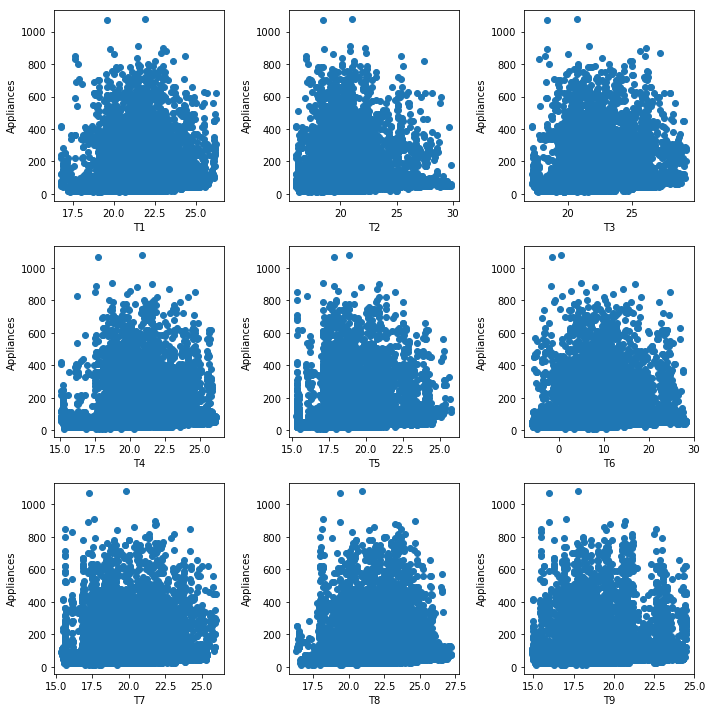

In [13]:
plt.figure(figsize=(10, 10))
nrow, ncol = dat.shape
for c in range(9):
    plt.subplot(3, 3, c+1)
    plt.plot(dat[:, 3 + c*2], dat[:,1],'o')
    plt.ylabel(names[1])
    plt.xlabel(names[3 + c*2])
plt.tight_layout()
plt.show()

Above plotted Application energy uses versus some variables. We can hardly see there is a relationship between them.

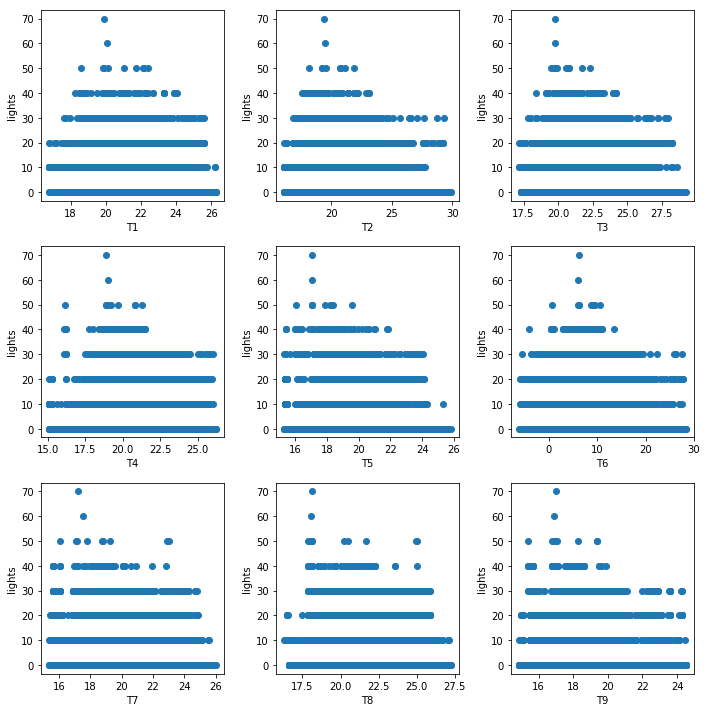

In [14]:
plt.figure(figsize=(10, 10))
nrow, ncol = dat.shape
for c in range(9):
    plt.subplot(3, 3, c+1)
    plt.plot(dat[:, 3 + c*2], dat[:,2],'o')
    plt.ylabel(names[2])
    plt.xlabel(names[3 + c*2])
plt.tight_layout()
plt.show()

Above plotted light energy uses versus some variables. We can hardly see there is a relationship between them.

## Results

In [15]:
T = np.float64(dat[:, 1:3])
X = np.float64(dat[:, 3:-2])
Tnames = names[1:3]
Xnames = names[3:-2]

In [16]:
Xtrain, Ttrain, Xtest, Ttest = shuffleIndice(X, T)

In [17]:
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((15788, 24), (15788, 2), (3947, 24), (3947, 2))

In [18]:
model = train(Xtrain, Ttrain)

In [19]:
predict = use(model, Xtest)

In [20]:
predict.shape, Ttest.shape

((3947, 2), (3947, 2))

In [21]:
error = rmse(predict, Ttest)

In [22]:
error

65.585939896907107

Using Matrix Calculation we get error is 67.3, which is ideally the best value (least).

In [23]:
learningRates = [0.1, 0.05, 0.01, 0.001]
for lr in learningRates:
    error = rmse(use(trainSGD(Xtrain, Ttrain, lr, 10), Xtest), Ttest)
    print("Learning rate", lr, "has error rate", error)

Learning rate 0.1 has error rate nan
Learning rate 0.05 has error rate 99.9639355458
Learning rate 0.01 has error rate 67.5060659441
Learning rate 0.001 has error rate 66.507601723


As we can see, given the same number of training data and iteration numbers, smaller learning rate will generate more accurate fitted model, (error rate more smaller/closer to the theoretical error rate).

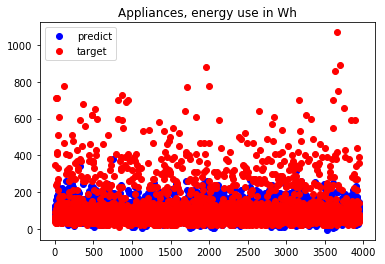

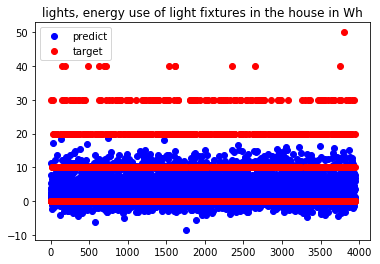

In [24]:
plt.plot(predict[:,0], 'o', color='blue', label = 'predict')
plt.plot(Ttest[:,0], 'o', color='red', label = 'target')
plt.legend()
plt.title("Appliances, energy use in Wh")
# plt.legend('predict', 'Target')
plt.show()

plt.plot(predict[:,1], 'o', color='blue', label = 'predict')
plt.plot(Ttest[:,1], 'o', color='red', label = 'target')
plt.legend()
plt.title("lights, energy use of light fixtures in the house in Wh")
# plt.legend('predict', 'Target')
plt.show()

Above plotted the predicted values versus target values using testing data set. We can see the predictions and real values do not match very well. It seems our fitted model does not perform well in this data set.

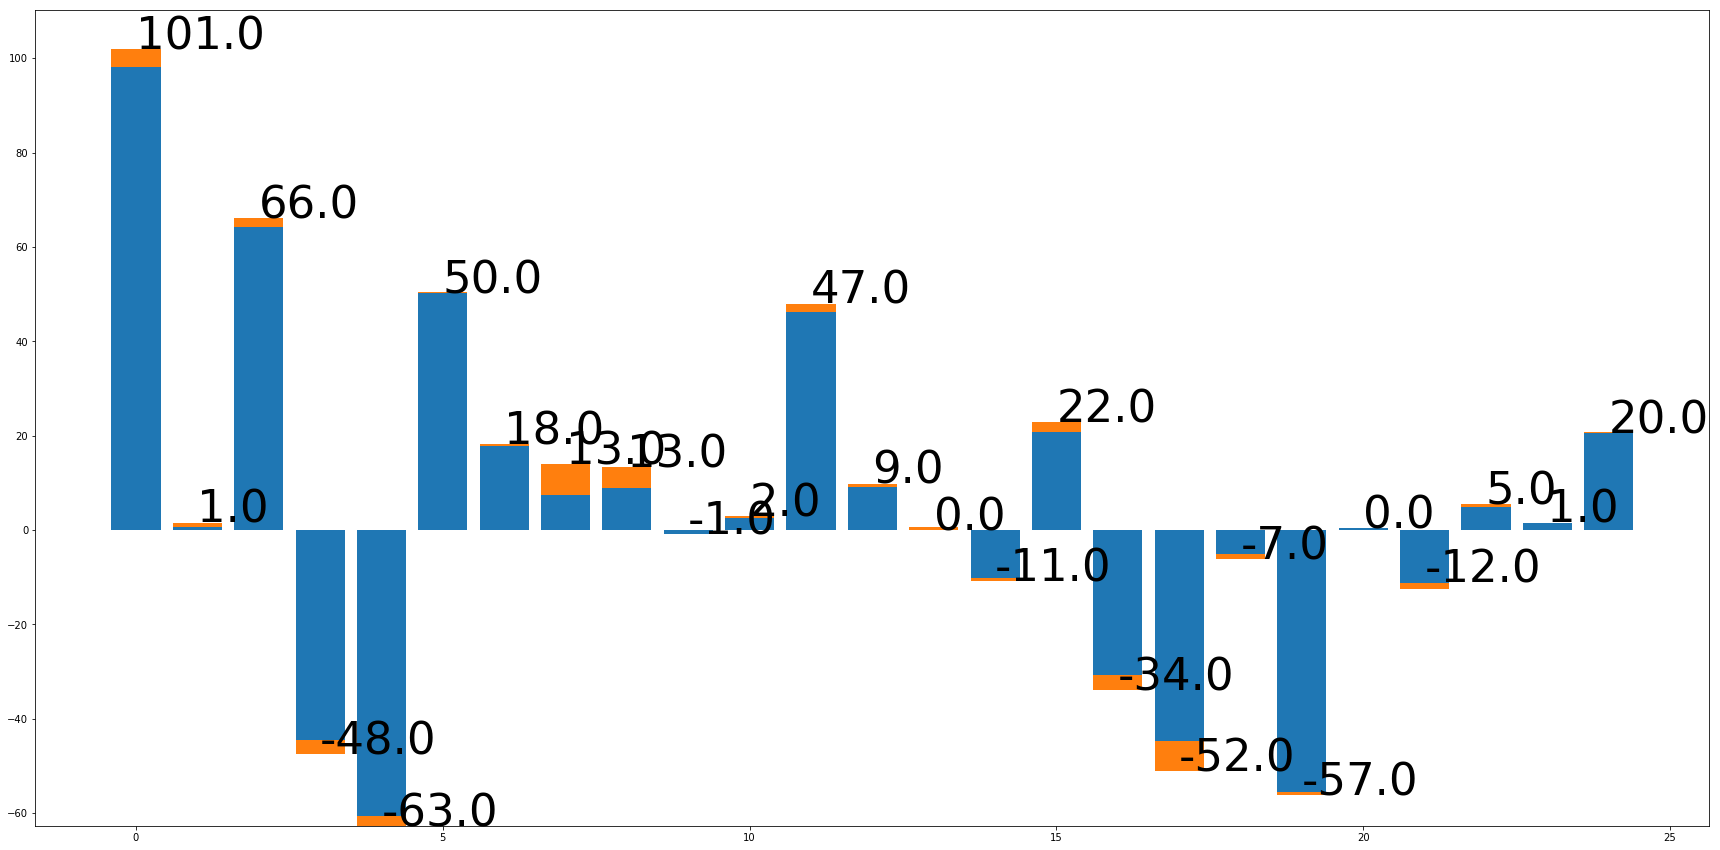

In [25]:
x = np.arange(25)
plt.figure(figsize=(30, 15))
plt.bar(x, model['w'][:,0])
plt.bar(x, model['w'][:,1],bottom=model['w'][:,0])
for i in range(25):
    plt.text(i, model['w'].sum(axis=1)[i], model['w'].sum(axis=1)[i]//1, fontsize=45)
plt.show()

As we can see, some varibles contributes much less than others (those have smaller weight in coffecient).

Now, a reduced model will be introduced by cutting off those less influential varibles (in this case, filter out varibles has less than 10 weight).

In [26]:
red = (model['w'].sum(axis=1)//1)[1:]
reded = np.where(abs(red)<=10)[0]
redx = np.where(abs(red)>10)[0]

In [27]:
names[3+reded]

array(['T1', 'T5', 'RH_5', 'RH_6', 'T7', 'RH_9', 'Press_mm_hg',
       'Windspeed', 'Visibility'], 
      dtype='<U11')

we removed 'T1', 'T5', 'RH_5', 'RH_6', 'T7', 'RH_7', 'RH_9', 'Press_mm_hg','RH_out', 'Windspeed', 'Visibility' since their coefficients are less than 10

In [28]:
redx

array([ 1,  2,  3,  4,  5,  6,  7, 10, 13, 14, 15, 16, 18, 20, 23])

In [29]:
redXtrain = Xtrain[:,redx]
redXtest = Xtest[:,redx]

In [30]:
Xtrain.shape, redXtrain.shape, redXtest.shape, Ttrain.shape, Ttest.shape

((15788, 24), (15788, 15), (3947, 15), (15788, 2), (3947, 2))

In [31]:
model = train(redXtrain, Ttrain)
predict = use(model, redXtest)
error = rmse(predict, Ttest)

In [32]:
error

65.851088496395136

In [33]:
learningRates = [0.1, 0.05, 0.01, 0.001]
for lr in learningRates:
    error = rmse(use(trainSGD(redXtrain, Ttrain, lr, 10), redXtest), Ttest)
    print("Learning rate", lr, "has error rate", error)

Learning rate 0.1 has error rate nan
Learning rate 0.05 has error rate 80.0164659065
Learning rate 0.01 has error rate 66.2499378876
Learning rate 0.001 has error rate 66.5923655544


Here is the comparsion between Full Model (with all variables) and Reduced Model (with influential variables). Rows are different learning rate, table values are rmse values for each fitted model.

|   |  Full Model |  Reduced Model  | Ideal Error
|---|---|---| --- |
| 0.1  | nan | 3671  | 67.3 |
| 0.05 | 304 |  89 | 67.3 |
| 0.01 | 74 |  70 | 67.3 |
| 0.001 | 68 | 68  | 67.3 |


With less influential variables filtered, SGD will be able to learn the linear regression model more quickly, while the final model accuracy does not change too much.

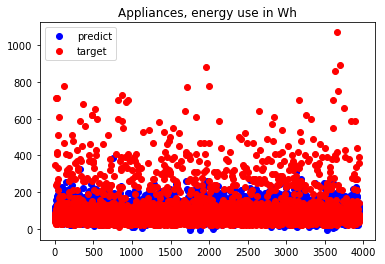

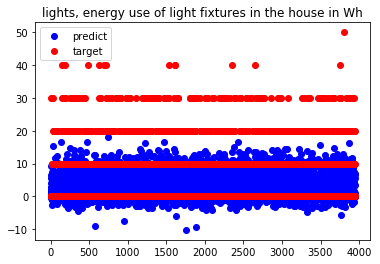

In [34]:
plt.plot(predict[:,0], 'o', color='blue', label = 'predict')
plt.plot(Ttest[:,0], 'o', color='red', label = 'target')
plt.legend()
plt.title("Appliances, energy use in Wh")
# plt.legend('predict', 'Target')
plt.show()

plt.plot(predict[:,1], 'o', color='blue', label = 'predict')
plt.plot(Ttest[:,1], 'o', color='red', label = 'target')
plt.legend()
plt.title("lights, energy use of light fixtures in the house in Wh")
# plt.legend('predict', 'Target')
plt.show()

Although we used reduced variables, the fitted model still does not perform ideally.

In [35]:
model = train(Xtrain, Ttrain)
predict = use(model, Xtrain)
error1 = rmse(predict, Ttrain)
predict = use(model, Xtest)
error2 = rmse(predict, Ttest)
error1, error2

(67.565573969499852, 65.585939896907107)

The model predict bad on light energy use, decent on appliances energy use. The RMSE for training data set is 66.76 while for the testing data set is 68.80, which are quite similar and close. So we can conclude that, although the model does not predicts very well on target values, but the model itself fits well considering RMSE for training and testing data.

In [36]:
%run -i "A1grader.py"


======================= Code Execution =======================

Extracting python code from notebook and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.
Testing rmse(A, B) with
 A =
[[1 2 3]
 [4 5 6]]
 and B =
[[2 3 4]
 [5 6 7]]

--- 10/10 points. Correctly returned 1.0

Testing model = train(X, T) with
 X=
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [18 20 22]
 [24 26 28]]
 and T=
[[  0.2   1.2]
 [  5.    6. ]
 [ 11.6  12.6]
 [ 62.   64. ]
 [ 96.8  98.8]]

--- 5/5 points. Model correctly includes a key named 'means'.

--- 5/5 points. Model correctly includes a key named 'stds'.

--- 5/5 points. Model correctly includes a key named 'w'.

Testing rmse(T, use(model, X))

--- 15/15 points. Error is correctly calculated as 5.2427092232928585.

Testing model = trainSGD(X, T, 0.01, 1000) with
 X=
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [18 20 22]
 [24 26 28]]
 and T=
[[  0.2   1.2]
 [  5.    6. ]
 [ 11.6  12.6]
 [ 62.   64. ]
 [ 96.8  98.8]

## Data Sample 2

In [37]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

This hourly data set contains the PM2.5 data of US Embassy in Beijing. Meanwhile, meteorological data from Beijing Capital International Airport are also included.

Attribute Information:

- No: row number 
- year: year of data in this row 
- month: month of data in this row 
- day: day of data in this row 
- hour: hour of data in this row 
- pm2.5: PM2.5 concentration (ug/m^3) 
- DEWP: Dew Point (â„ƒ) 
- TEMP: Temperature (â„ƒ) 
- PRES: Pressure (hPa) 
- cbwd: Combined wind direction 
- Iws: Cumulated wind speed (m/s) 
- Is: Cumulated hours of snow 
- Ir: Cumulated hours of rain 



In [38]:
df = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [39]:
df.cbwd.unique()

array(['NW', 'cv', 'NE', 'SE'], dtype=object)

In [40]:
mapping = {'NE': 1, 'NW': 2, 'SE': 3, 'cv': 4}
df = df.dropna(axis=0, how='any')
df = df.replace({'cbwd': mapping})
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,3,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,3,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,3,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,3,6.25,2,0
29,30,2010,1,2,5,109.0,-7,-6.0,1022.0,3,7.14,3,0
30,31,2010,1,2,6,105.0,-7,-6.0,1023.0,3,8.93,4,0
31,32,2010,1,2,7,124.0,-7,-5.0,1024.0,3,10.72,0,0
32,33,2010,1,2,8,120.0,-8,-6.0,1024.0,3,12.51,0,0
33,34,2010,1,2,9,132.0,-7,-5.0,1025.0,3,14.30,0,0


In [41]:
df["pm2.5"].max(), df["pm2.5"].min()

(994.0, 0.0)

In [42]:
names = np.array(list(df))
names

array(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP',
       'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], 
      dtype='<U5')

In [43]:
dat = df.as_matrix()

In [44]:
dat.shape

(41757, 13)

In [45]:
T = np.float64(dat[:, 5]).reshape(-1, 1)
X = (np.delete(dat, [0,5], 1))

In [46]:
T

array([[ 129.],
       [ 148.],
       [ 159.],
       ..., 
       [  10.],
       [   8.],
       [  12.]])

In [47]:
X.shape, T.shape

((41757, 11), (41757, 1))

In [48]:
Xtrain, Ttrain, Xtest, Ttest = shuffleIndice(X, T)

#### Theoretically Model:

In [49]:
model = train(Xtrain, Ttrain)

In [50]:
predict = use(model, Xtest)

In [51]:
error = rmse(predict, Ttest)

In [52]:
error

78.206960308200664

In [53]:
learningRates = [0.1, 0.05, 0.01, 0.001]
for lr in learningRates:
    error = rmse(use(trainSGD(Xtrain, Ttrain, lr, 10), Xtest), Ttest)
    print("Learning rate", lr, "has error rate", error)

Learning rate 0.1 has error rate nan
Learning rate 0.05 has error rate nan
Learning rate 0.01 has error rate 80.8430732248
Learning rate 0.001 has error rate 78.512021296


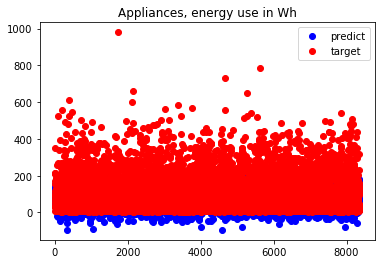

In [54]:
plt.plot(predict[:,0], 'o', color='blue', label = 'predict')
plt.plot(Ttest[:,0], 'o', color='red', label = 'target')
plt.legend()
plt.title("Appliances, energy use in Wh")
# plt.legend('predict', 'Target')
plt.show()

In [55]:
model['w'].sum(axis=1)[0]
model['w'][:,0]

array([ 98.675687  ,   1.19256603,  -4.80828251,   6.81733139,
        10.13316679,  65.25686638, -79.31177593, -15.72702039,
        10.4955857 , -11.05786804,  -2.18335902,  -9.8796474 ])

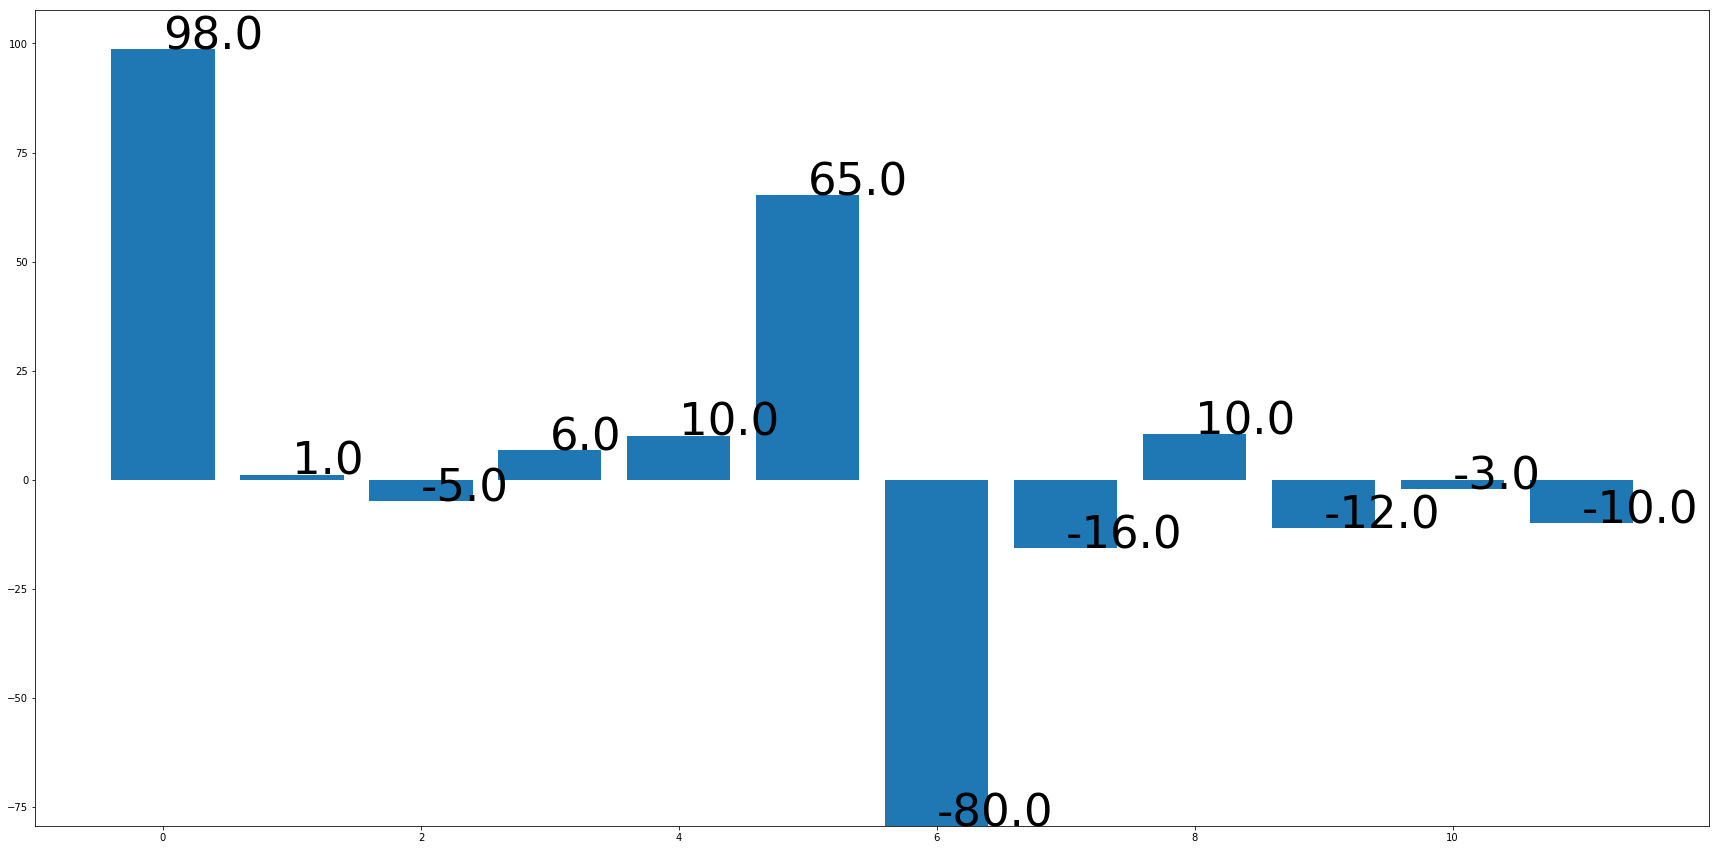

In [56]:
x = np.arange(12)
plt.figure(figsize=(30, 15))
plt.bar(x, model['w'][:,0])
for i in range(12):
    plt.text(i, model['w'].sum(axis=1)[i], model['w'].sum(axis=1)[i]//1, fontsize=45)
plt.show()

In [57]:
red = (model['w'].sum(axis=1)//1)[1:]
reded = np.where(abs(red)<=10)[0]
redx = np.where(abs(red)>10)[0]

In [58]:
redXtrain = Xtrain[:,redx]
redXtest = Xtest[:,redx]

In [59]:
redXtrain.shape, Ttrain.shape

((33406, 4), (33406, 1))

In [60]:
learningRates = [0.1, 0.05, 0.01, 0.001]
for lr in learningRates:
    error = rmse(use(trainSGD(redXtrain, Ttrain, lr, 10), redXtest), Ttest)
    print("Learning rate", lr, "has error rate", error)

Learning rate 0.1 has error rate 85.301918164
Learning rate 0.05 has error rate 82.3169189776
Learning rate 0.01 has error rate 81.4877361229
Learning rate 0.001 has error rate 80.7110089395


In [61]:
model = train(Xtrain, Ttrain)

In [62]:
predict = use(model, Xtest)

In [63]:
error = rmse(predict, Ttest)

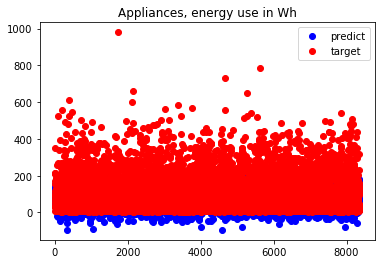

In [64]:
plt.plot(predict[:,0], 'o', color='blue', label = 'predict')
plt.plot(Ttest[:,0], 'o', color='red', label = 'target')
plt.legend()
plt.title("Appliances, energy use in Wh")
# plt.legend('predict', 'Target')
plt.show()

The predict model obviously does not work well in test data

## One More Date Sample

In [65]:
nSamples = 100
X = np.random.uniform(0,10,(nSamples,1))
T = 2 - 0.1 * X + np.random.normal(0,0.1,(nSamples,1)) + 0.0*(X-6)**2 # Change 0 to 0.05 to try to fit nonlinear cloud

X1 = np.insert(X, 0, 1, axis=1)

X1.shape, T.shape

((100, 2), (100, 1))

In [66]:
(standardize, unStandardize) = makeStandardize(X)
    
means, stds, XStd = standardize(X)

In [67]:
plt.plot(XStd, T, 'o', alpha=0.6, label='Data')

In [68]:
model = train(X, T)

In [69]:
model['w'], model['w'][0], model['w'][1]

(array([[ 1.51381107],
        [-0.29351327]]), array([ 1.51381107]), array([-0.29351327]))

In [70]:
model = trainSGD(X, T, 0.01, 20)

In [71]:
model['w'][0], model['w'][1]

(array([ 1.50984093]), array([-0.29509595]))

In [72]:
error = rmse(use(model, X), T)
print("Learning rate", lr, "has error rate", error)

Learning rate 0.001 has error rate 0.0999896538879


In [73]:
predict = use(model, X)

In [74]:
x = np.arange(10, step = 0.4)
x.shape

(25,)

In [75]:
model['w'][0], model['w'][1]

(array([ 1.50984093]), array([-0.29509595]))

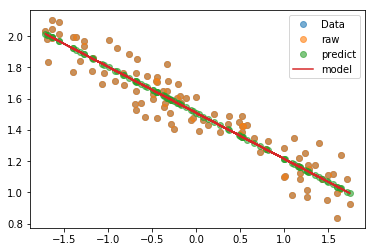

In [76]:
plt.plot(XStd, T, 'o', alpha=0.6, label='raw')
plt.plot(XStd, predict, 'o', alpha=0.6, label='predict')
plt.plot(XStd, model['w'][0] + model['w'][1] * XStd, label='model')
plt.legend()
plt.show()

In [77]:
T.shape, predict.shape

((100, 1), (100, 1))

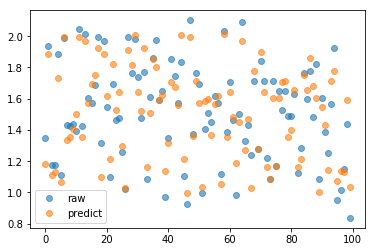

In [78]:
plt.plot(T, 'o', alpha=0.6, label='raw')
plt.plot(predict, 'o', alpha=0.6, label='predict')
# plt.plot(XStd, model['w'][0] + model['w'][1] * XStd, label='model')
plt.legend()
plt.show()

## Last Example

In [79]:
X = np.arange(10).reshape((5,2))
T = X[:,0:1] + 2 * X[:,1:2] + np.random.uniform(-1, 1,(5, 1))
print('Inputs')
print(X)
print('Targets')
print(T)

Inputs
[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
Targets
[[  2.42244994]
 [  8.92460373]
 [ 13.04698416]
 [ 20.27692812]
 [ 25.3702177 ]]


In [80]:
model = train(X, T)
model

{'means': array([ 4.,  5.]),
 'stds': array([ 2.82842712,  2.82842712]),
 'w': array([[ 14.00823673],
        [  4.04803499],
        [  4.04803499]])}

In [81]:
predicted = use(model, X)
predicted

array([[  2.55866475],
       [  8.28345074],
       [ 14.00823673],
       [ 19.73302272],
       [ 25.45780871]])

In [82]:
rmse(predicted, T)

0.57569842698802287

In [83]:
modelSGD = trainSGD(X, T, 0.01, 100)
modelSGD

{'means': array([ 4.,  5.]),
 'stds': array([ 2.82842712,  2.82842712]),
 'w': array([[ 13.9211975 ],
        [  4.04792086],
        [  4.04792086]])}

In [84]:
predicted = use(modelSGD, X)
predicted

array([[  2.47194833],
       [  8.19657291],
       [ 13.9211975 ],
       [ 19.64582208],
       [ 25.37044666]])

In [85]:
rmse(predicted, T)

0.58224098030493543

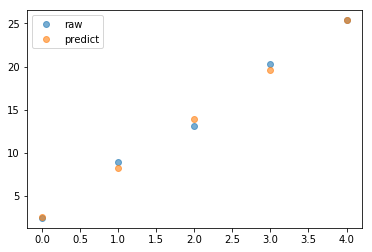

In [86]:
plt.plot(T, 'o', alpha=0.6, label='raw')
plt.plot(predicted, 'o', alpha=0.6, label='predict')
# plt.plot(XStd, model['w'][0] + model['w'][1] * XStd, label='model')
plt.legend()
plt.show()